# Distance Based Method

There are lots of these methods. In my opinion they are all quote obtuse, that is they require some methods which almost feel like brute force.  

Some correlation needs to be found and from that some transformation can be derived. There are a few good correlation methods in scymy and numpy.  
https://stackoverflow.com/questions/24034839/valueerror-resizing-an-ndarray  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html  

Note on correlate2d:
> The output is the full **discrete linear cross-correlation** of the inputs. 

In [47]:
import imageio
import math

import numpy as np
import scipy as sp

## Some different similarity measurements

These similarity measurements do not work nicely but as a proof of concept they're interesting. Each one is just a little off what `correlate2d` can deliver. 

Per ms-registration-manual, NCC will not work well with these images:

> Note, however, that the NCC score is undefined if either of the two patches has zero variance (and in fact, its performance degrades for noisy low-contrast regions).

SAD and SSD do not work well either. MI actually gives a decent transformation! 

Note, with these methods we are not considering fractional displacements, I would suspect that `correlate2d` doesn't either. Per ibid:

> In general, the displacement u can be fractional, so a suitable interpolation function must be applied to image I1(x).

A final method which improves the accuracy of NCC on noisy images is implemented as NCC whiten, this looks like it helps it work well on these images. (Berberidis, Kerybali)

In [78]:
def fill_fn(fn, size):
    name = fn.__name__
    if name == 'NCC' or name == 'MI':
        return np.zeros(size)
    elif name == 'SSD' or name == 'SAD':
        return np.full(size, np.inf)

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    offset_h, offset_w = (int(th/2), int(tw/2))
    op_res = fill_fn(op, (h_len, w_len))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            # slice im to be the area under the template
            op_res[i+offset_h, j+offset_w] = op(im[i:i+th, j:j+tw], template)
    return op_res

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes "%s" v "%s"' % (i1.shape, i2.shape,) 
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def SSD(i1, i2):
    '''
    Sum squared differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_square = np.square(i2 - i1).sum() # (A - B)^2 
    return sum_square

def SAD(i1, i2):
    '''
    sum absolute differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_absolute = (abs(i2 - i1)).sum() # | A - B | 
    return sum_absolute

def MI(X,Y):
    '''
    Mutual information, maximize this
    '''
    X = np.ravel(X)
    Y = np.ravel(Y)
    c_XY = np.histogram2d(X,Y, normed=True)[0]
    c_X = np.histogram(X, normed=True)[0]
    c_Y = np.histogram(Y, normed=True)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    return H_X + H_Y - H_XY

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    return -sum(c_normalized* np.log2(c_normalized)) # same as scipy.stats.entropy(c_norm, base=2)


# NCC whitening
from sklearn.linear_model import LinearRegression

def lpc(a,b):
    '''
    create a 2d linear prediction and return the coefficients
    '''
    lr = LinearRegression()
    lr.fit(a,b)
    return lr.coef_

def NCC_whiten(im1, im2):
    '''
    whiten the images based on a '2D prediction error filter' of the reference image (im1)
    '''
    a_pred = lpc(im1, im2)
    im1 += np.square(abs(im1 - a_pred))
    im2 += np.square(abs(im2 - a_pred))
    return (im1, im2)

In [188]:
from PIL import Image

s = 64
newsize = (s,s)
temp1 = Image.open('../data/T1_segment_1.tif').resize(newsize)
temp2 = Image.open('../data/T1_segment_2.tif').resize(newsize)

im1 = np.array(temp1).astype('float64')
p = int(im1.shape[0])
im1 = np.pad(im1, ((p,p), (p,p)), 'constant', constant_values=(0,0))
im2 = np.array(temp2).astype('float64')

In [189]:
from scipy import signal
from scipy import misc

# face     = im1 - im1.mean()
# template = im2 - im2.mean()
# corr = signal.correlate2d(face, template, mode='same')
# y, x = np.unravel_index(np.argmax(corr), corr.shape)

face = im1
template = im2
corr = convolve(face, template, MI)
y, x = np.unravel_index(np.argmax(corr), corr.shape)

# # For this method we need to whiten the images slightly beforehand.
# face, template = NCC_whiten(np.array(temp1).astype('float64'), np.array(temp2).astype('float64'))
# face = np.pad(face, ((p,p), (p,p)), 'constant', constant_values=(0,0))
# corr = convolve(face, template, NCC)
# y, x = np.unravel_index(np.argmax(corr), corr.shape)

In [190]:
corr.shape

(192, 192)

In [191]:
x-p,y-p

(70, 32)

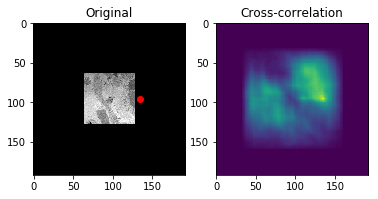

In [211]:
import matplotlib.pyplot as plt

def show_registration(padded_image, correlation, coord):
    fig, (ax_orig, ax_corr) = plt.subplots(1, 2, figsize=(6, 12))
    ax_orig.imshow(padded_image, cmap='gray')
    ax_orig.set_title('Original')
    ax_corr.imshow(correlation)
    ax_corr.set_title('Cross-correlation')
    ax_orig.plot(coord[0], coord[1], 'ro')
    plt.show()
    
show_registration(face, corr, (x,y))

merge the images given the x,y homography

In [193]:
from math import floor
from PIL import Image

def paste(canvas, paint):
    '''
    Paste an image on to another using masks.
    '''
    h, w = canvas.shape
    p_h, p_w = paint.shape
    nw, nh = (0,0)
    if w < p_w:
        nw = p_w - w
    if h < p_h:
        nh = p_h - h
    output = np.copy(canvas)
    output = np.pad(output, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    assert output.shape[0] == paint.shape[0], 'different heights: %d %d'% (output.shape[0], paint.shape[0])
    assert output.shape[1] == paint.shape[1], 'different widths: %d %d' % (output.shape[1], paint.shape[1])
    # mask magic!
    o_mask = np.ma.equal(output, 0)
    output[o_mask] = paint[o_mask] # for places where output is 0: paint.
    return output

In [194]:
half_y = int(temp1.size[0] / 2)
half_x = int(temp1.size[1] / 2)

nx = x - p
ny = y - p

# There is the assumption here that the image is below or right of the reference image
nx = nx - half_x
ny = ny - half_y

sides = (nx,0)
if nx < 0:
    sides = (0, abs(nx))

verts = (ny,0)
if ny < 0:
    verts = (0, abs(ny))

# temp4 = np.pad(np.asarray(temp2, dtype='uint16'), ((ny, 0), (nx, 0)), 'constant', constant_values=(0,0))
temp4 = np.pad(np.asarray(temp2, dtype='uint16'), (verts, sides), 'constant', constant_values=(0,0))
im3 = paste(np.asarray(temp1, dtype='uint16'), temp4)

In [195]:
nx, ny

(38, 0)

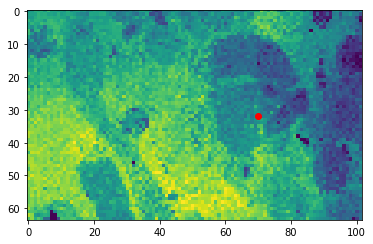

In [196]:
plt.imshow(im3)
axs = plt.gca()
axs.plot(nx+half_x, ny+half_y, 'ro')
plt.show()

## Heirarchical Schemes

(We shouldn't call them "pyramid schemes", those are somehting else. Go with "pyramid**al**".) This strategy uses the initial transformation from the convolution to significantly narrow down the search space, using just a few levels these (3-4) it should be possible to stitch the full size images precisely.  

This still takes a long time. The whole image is still convolved and a lot of it is over 0 valued pixels. There should be a way to just examine the pixels of the reference image which have values. This is an absurdly naive scheme and needs improvement. Imrpovements to be made: 

- Faster similarity measurement (MI is much too slow here, NCC just about tolerable).
- Subsampling / smoothing as you **ascend** the pyramid?
- smaller search window for each level? (start larger, narrow it down as you ascend)
- smarter convolution, i.e. ignore the empty pixels more
- do some sort of filtering between the levels which enhances the maximums.

In [220]:
from math import ceil

def convolve_range(im, template, op, ranges=None):
    '''
    ranges in the form of ((x1, y1),(x2, y2))
    '''
    h_len, w_len = im.shape
    th, tw = template.shape
    offset_h, offset_w = (int(th/2), int(tw/2))
    op_res = fill_fn(op, (h_len, w_len))
    if ranges != None:
        start_i, start_j = ranges[0]
        end_i, end_j = ranges[1]
        for i in range(start_i, end_i):
            for j in range(start_j, end_j):
                # print('i: %d:%d, j: %d:%d' % (i, i+th, j, j+tw))
                op_res[i+offset_h, j+offset_w] = op(im[i:i+th, j:j+tw], template)
#         return op_res[start_i:end_i, start_j:end_j]
        return op_res    
    
    for i in range(start_i, h_len-th+1):
            for j in range(start_j, w_len-tw+1):
                op_res[i+offset_h, j+offset_w] = op(im[i:i+th, j:j+tw], template)
    return op_res

def objective_function(measurement): 
    name = measurement.__name__
    if name == 'NCC' or name == 'MI':
        return np.argmax
    elif name == 'SSD' or name == 'SAD':
        return np.argmin

def pyramidal(ref_name, mov_name, measurement, levels=[0.05, 0.25, 0.5]):
    '''
    Find a better transformation, from a previously found one, on progressively larger images.
    levels is an array of: tuples with pixel sizes, integers to be pixel_sizes, floats as a percentage.
    '''
    p = 0 # size of moving image
    T      = (None, None) # transformation, (y,x)
    temp_T = (None, None) # temporary_T, these are the unscaled values from the correlation matrix
    prev_level = None # previous hierarchy
    w_size = 32       # window size, each level after the first examines from Tx-w_size, Tx+w_size
    ref_src = Image.open('../data/%s' % ref_name) # reference image
    mov_src = Image.open('../data/%s' % mov_name) # moving image
    # begin
    for level in levels:
        new_size = None
        if type(level) is tuple:
            assert level[0].is_integer(), 'pixel size in tuple must be an integer'
            new_size = level
        elif level <= 1.0:
            ny, nx = ref_src.size
            new_size = (ceil(ny * level), ceil(nx * level))
        print('level: %.02f, size:%s, T:%s' % (level, new_size, T,))
        assert sum(new_size) <= sum(ref_src.size), 'the image is being scaled up, should always be scaled down'
        if T != (None, None):
            # difference in scale
            level_diff = (level / prev_level)
            # scale images
            ref = np.array(ref_src.copy().resize(new_size)).astype('float64')
            mov = np.array(mov_src.copy().resize(new_size)).astype('float64')
            # pad ref image
            p = int(mov.shape[0])
            ref = np.pad(ref, ((p,p), (p,p)), 'constant', constant_values=(0,0))
            # establish a range to look for a better T, scale T, add offsets
            ranges = (                                                            \
                      (int(T[0]*level_diff-w_size), int(T[1]*level_diff-w_size)), \
                      (int(T[0]*level_diff+w_size), int(T[1]*level_diff+w_size))  \
                     )
            # find next T
            # print(T, ref.shape, mov.shape, ranges, level_diff)
            corr = convolve_range(ref, mov, measurement, ranges=ranges)
            temp_T = np.unravel_index(objective_function(measurement)(corr), corr.shape)
        else:
            # rescale images
            ref = np.array(ref_src.copy().resize(new_size)).astype('float64')
            mov = np.array(mov_src.copy().resize(new_size)).astype('float64')
            # pad reference     
            p = int(mov.shape[0])
            ref = np.pad(ref, ((p,p), (p,p)), 'constant', constant_values=(0,0))
            # find initial T
            corr = convolve(ref, mov, measurement)
            temp_T = np.unravel_index(objective_function(measurement)(corr), corr.shape)

        T = (int(temp_T[0] - int(p/2)), \
             int(temp_T[1] - int(p/2)) )
        show_registration(ref, corr, temp_T[::-1])
        prev_level = level
        
    return ref_src, mov_src, T

level: 0.05, size:(128, 128), T:(None, None)


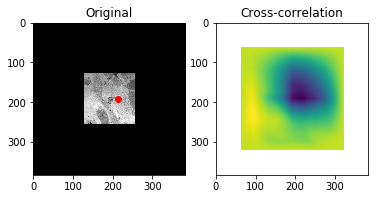

level: 0.25, size:(640, 640), T:(128, 151)


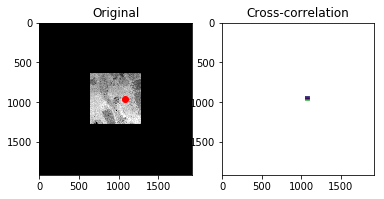

level: 0.50, size:(1280, 1280), T:(640, 757)


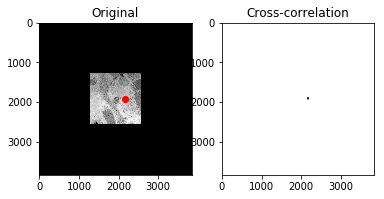

(1280, 1513)

In [222]:
ref, mov, transformation = pyramidal('T1_segment_1.tif', 'T1_segment_2.tif', SSD)
transformation